# Search TSX Shape File Catalog to Find Frames that Contain a Point
---

This notebook lets the user search of all frames tha contain a point, and then further narrow the selection based on attributes like date, mode, track, etc. The results are saved in a shape file. 

The procedure will work best if you first identify the lat/lon coordinates for your area of interest and then verify that data exist for that point either using the legacy tool or viewing the shape file arcgis or qgis.

## Python Setup Stuff

In [1]:
import geopandas as gpd
from datetime import datetime
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.ops import transform
import pyproj
import contextily as ctx

Setup transform for plotting points in map coordinates used by contextily.

In [2]:
mapProjection = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3857')).transform
invMapProjection = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:3857'), pyproj.CRS('EPSG:4326')).transform

In [3]:
def formatDate(dateString):
    ''' Convert date string for a column to date time values'''
    return np.array([datetime.strptime(x,'%Y-%m-%d') for x in dateString])

In [4]:
def filterDate(myDB, firstDate, lastDate):
    ''' Filter tsxDB by date range '''
    dates = formatDate(myDB['start_time']) 
    return myDB[np.logical_and(dates >= firstDate, dates <= lastDate)].sort_values(by='start_time')

In [5]:
def searchCircle(lat, lon, radius):
    pxy = Point(transform(mapProjection, Point(lat, lon)).coords[:][0])
    #pxy = Point(xpt, ypt)
    xyCircle = pxy.buffer(radius * 1000)
    llCircle = transform(invMapProjection, xyCircle)
    # Swap lat/lon for different convention used by pandas
    llCircle = Polygon([(x[1], x[0]) for x in llCircle.exterior.coords[:]])
    return llCircle, xyCircle

def filterRadius(myDB, lat, lon, radius):
    ''' Find tracks that contain a point'''
    llCircle, _ = searchCircle(lat, lon, max(radius, 1))
    return myDB[myDB['geometry'].intersects(llCircle)]

In [6]:
def filterProperties(myDB, properties):
    ''' Filter on a dictionary of properties '''
    result = myDB
    for key in properties:
        if properties[key] is not None:
            result = result[result[key] == properties[key]]
    return result

In [7]:
def filterIncidence(myDB, incMin, incMax):
    ''' Filter by incidence angle range'''
    return myDB[np.logical_and(myDB['inc_min'] >= incMin, myDB['inc_max'] <= incMax)]

In [8]:
def plotSearch(myResult, lat, lon, radius, zoom=10, **keywords):
    ''' Plot the search results '''
    ax = myResult.to_crs(epsg=3857).plot(edgecolor='k', facecolor="none", **keywords)
    ax.set_aspect('equal')
    ctx.add_basemap(ax, zoom=zoom)
    _, xyCircle = searchCircle(lat, lon, max(radius, 3))
    x, y = xyCircle.exterior.xy
    ax.plot(x, y, 'r*', linewidth=2, color='r')
    return ax

## Read and Filter TSX Database

The following steps will read the catalog, apply various filters, and plot intermediate and final results.

### Read Catalog

This step reads the catlog and displays the first line to show the column headings.

In [11]:
tsxDB = gpd.read_file('zip://cat0Polygon.zip')
tsxDB.head(1)

,id,mission,category,quality,img_mod,inc_min,inc_max,abs_orbit,rel_orbit,looking_di,...,start_time,cat_time,resolution,datastack,resolutio0,resolutio1,browseimag,start_tim0,stop_time_,geometry
0,TSX-1_2013-12-21T11_59_5203165,TSX-1,0,AUTO_APPROVED,Stripmap (SM),33.010539,34.500304,36154,82,R,...,2013-12-21,2013-12-22,Approximated Resolution Range: 6.6 m,76.0,6.6,6.6,https://terrasar-x-archive.terrasar.com/downlo...,2013-12-21,2013-12-21,"POLYGON ((-88.97313 29.28657, -88.80256 29.259..."


### Define search params.

Everything needed to define the search is specified here. The notebook may need to be run once or twice to pick the final values based on the intermediate results. For example, the relative orbit should be picked after the first step to narrow by location and time. Likewise the incidence angle after seeing the range of incidence angles.

In [10]:
lat, lon = 58.587, -133.969  # Find frames that contain this point
searchPoint = Point(lat, lon)
radius = 0  # Change set to a value > 0 for non-point search
firstDate, lastDate = datetime(2009,1,1), datetime(2015,12,31)  # Find frames in this date range
properties = {'img_mod': 'Stripmap (SM)',  # Imaging mode
              'looking_di': 'R',   # Lookdir, almost always R for right
              'path_dir': 'ascending',  # ascending or descending
              'rel_orbit': 137}     # relative orbit
incidenceAngleMin = 34.
incidenceAngleMax = 40. 
dTthresh = 22  # Maximum temporal spacing for insar pairs - change to None if not applicable
resultsFile = 'TakuGlacier.137.shp'  # The name of the file with results (end with .shp for shape file and .csv for csv)

Check to make sure parameters specified are valid.

In [11]:
for key in properties:
    if key not in tsxDB.columns:
        print(f'Property {key} is not valid')

### Narrow By Location and Time

For this stage, the data based is narrowed by time and location so that all tracks over the desired point and during the desired interval are displayed. If this takes too long to run, try reducing zoom value for *plotSearch*. Subsequent steps should be faster.

Search returned 27 products


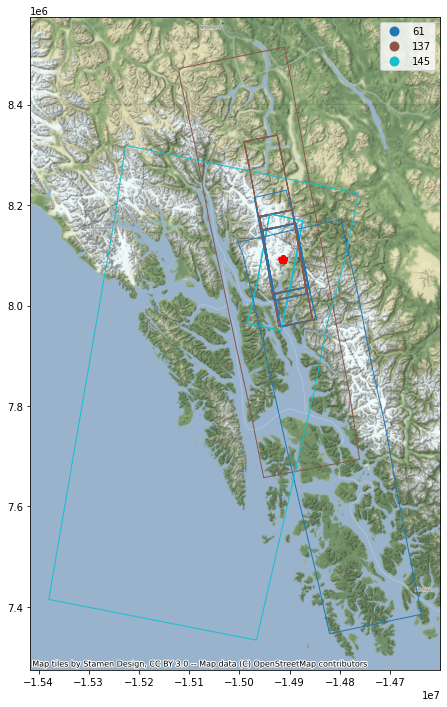

In [13]:
myResultSpace = filterRadius(tsxDB, lat, lon, radius)  # Narrow by Location
myResultTime = filterDate(myResultSpace, firstDate, lastDate)  # Narrow by date range
plotSearch(myResultTime, lat, lon, radius, zoom=8, column='rel_orbit', figsize=(8,12), legend=True, categorical=True)
print(f'Search returned {myResultTime.shape[0]} products')

### Narrow Futher by Properties

This further narrows the search using a dictionary of properties (e.g., relative orbit, ascending or descending, mode). The remaining results are listed by incidence angle.

Search returned 13 products


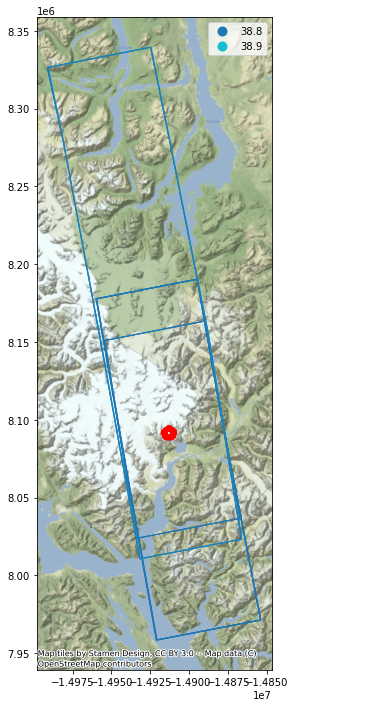

In [14]:
myResultProperties = filterProperties(myResultTime, properties)  # Narrow by properties
myResultProperties['inc_max'] = myResultProperties['inc_max'].round(1)  # Round the result to avoid to many legend entries
plotSearch(myResultProperties, lat, lon, radius, column='inc_max', figsize=(8,12), legend=True, categorical=True)
print(f'Search returned {myResultProperties.shape[0]} products')

### Reduce by Incidence Angle

Search returned 13 products


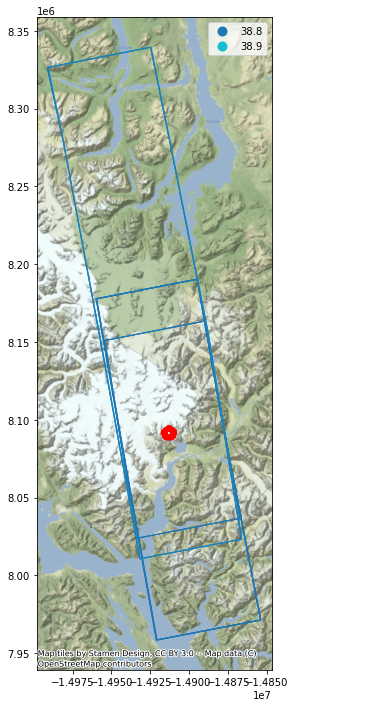

In [15]:
myResultAngle = filterIncidence(myResultProperties, 34, 40)
plotSearch(myResultAngle, lat, lon, radius, column='inc_max', figsize=(8,12), legend=True, categorical=True)
print(f'Search returned {myResultAngle.shape[0]} products')

### Filter for Interferometric Pairs

This step will eliminate images that don't belong to a pair with seperation of dTthresh days or less. If dThresh=None, it will save the result as final with no change.

Search returned 12 products


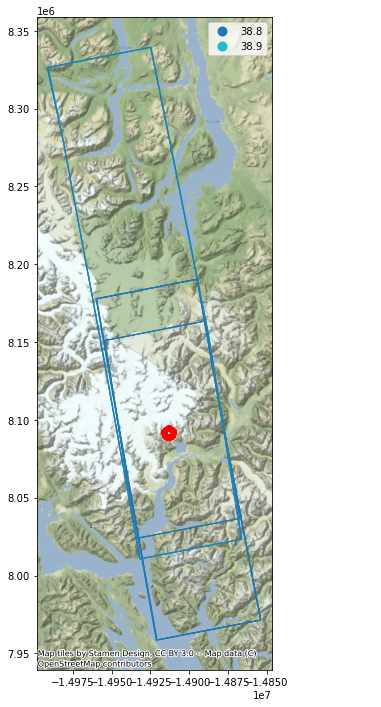

In [16]:
if dTthresh is not None:
    dates = formatDate(myResultAngle['start_time'])
    forwards = [ (dates[i+1] - dates[i]).days <= dTthresh for i in range(0,len(dates)-1)] + [True] # check forward in time pairs
    backwards = [True] + [ (dates[i] - dates[i-1]).days <= dTthresh for i in range(1,len(dates))] # check backwards in time pairs
    keep = np.logical_or(forwards, backwards)  #  Union of all valid pairs.
    myResultFinal = myResultAngle[keep]  # Remove invalid images
else:
    myResultFinal = myResultAngle  # No change
plotSearch(myResultFinal, lat, lon, radius, column='inc_max', figsize=(8,12), legend=True, categorical=True)
print(f'Search returned {myResultFinal.shape[0]} products')

## Summarize and Save Results

List final results.

In [17]:
myResultFinal[['id', 'mission', 'abs_orbit', 'rel_orbit', 'start_time']].sort_values(by='start_time')

,id,mission,abs_orbit,rel_orbit,start_time
89846,TSX-1_2009-06-08T02_31_4084044,TSX-1,10992,137,2009-06-08
85815,TSX-1_2009-06-19T02_31_4155156,TSX-1,11159,137,2009-06-19
177276,TSX-1_2009-07-11T02_31_4231887,TSX-1,11493,137,2009-07-11
92918,TSX-1_2009-07-22T02_31_4289507,TSX-1,11660,137,2009-07-22
80261,TSX-1_2009-08-13T02_31_446783,TSX-1,11994,137,2009-08-13
177210,TSX-1_2010-07-09T02_31_5338313,TSX-1,17004,137,2010-07-09
80829,TSX-1_2010-07-20T02_31_5377445,TSX-1,17171,137,2010-07-20
79305,TSX-1_2010-08-11T02_31_5490849,TSX-1,17505,137,2010-08-11
88888,TDX-1_2011-07-07T02_31_5703931,TDX-1,5785,137,2011-07-07
90439,TSX-1_2011-07-29T02_31_5846924,TSX-1,22849,137,2011-07-29


Write the result to a csv or shapefile.

In [19]:
if resultsFile.endswith('csv'):
    myResultFinal.to_csv(resultsFile)
else:
    myResultFinal.to_file(resultsFile)